In [118]:
import numpy as np
from typing import Callable
args = {
    'a_const': 1,
    'b_const': 0,
    'c_const': -2,
    'd_const': 2,
    'l': np.pi / 2,
    'Function': lambda: 0,
    'alpha': 1,
    'beta': 0,
    'gamma': 1,
    'delta': 0,
    'Psi1': lambda x: np.exp(-x) * np.cos(x),
    'Psi2': lambda x: 0,
    'Psi11': lambda x: -np.exp(-x) * np.sin(x) - np.exp(-x) * np.cos(x),
    'Psi12': lambda x:  2 * np.exp(-x) * np.sin(x),
    'Phi0': lambda t: np.exp(-t) * np.cos(2 * t),
    'PhiL': lambda t: 0,
    'type': '1-2',
    'acc_level': 1,
    'analitycal_solve': lambda x, t: np.exp(-x) * np.cos(x) * np.cos(2 * t),
    'algorithm': 'implicit_solve'
}

In [119]:
class Solver:
    a_const: int = 0
    b_const: int = 0
    c_const: int = 0
    d_const: int = 0
    l: float = 0
    Function: int = 0
    alpha: int = 0
    beta: int = 0
    gamma: int = 0
    delta: int = 0
    Psi1: Callable
    Psi2: Callable
    Psi11: Callable
    Psi12: Callable
    Phi0: Callable
    PhiL: Callable
    type: str
    acc_level: int = 0
    analitycal_solve: Callable
    algorithm: str


    def __init__(self, args):
        for name, value in args.items():
            setattr(self, name, value)
        func_name = args['algorithm']
        self.FunctionName = getattr(self, func_name)

    def solve(self, N, K, T):
        self.h = self.l/ N;
        self.tau = T / K;
        self.sigma = (self.tau ** 2) / (self.h ** 2)
        return self.FunctionName(N, K, T)

    def get_analitycal_solution_matrix(self, N, K, T):
        self.h = self.l / N;
        self.tau = T / K;
        self.sigma = (self.tau ** 2) / (self.h ** 2)
        self.u = np.zeros((K, N))
        for k in range(K):
            for j in range(N):
                self.u[k][j] = self.analitycal_solve(j * self.h, k * self.tau)
        return self.u

    def run_method(self):
        size = len(self.a)
        p = np.zeros(size)
        q = np.zeros(size)
        p[0] = (-self.c[0] / self.b[0])
        q[0] = (self.d[0] / self.b[0])

        for i in range(1, size):
            p[i] = -self.c[i] / (self.b[i] + self.a[i] * p[i - 1])
            q[i] = (self.d[i] - self.a[i] * q[i - 1]) / (self.b[i] + self.a[i] * p[i - 1])

        x = np.zeros(size)
        x[-1] = q[-1]

        for i in range(size - 2, -1, -1):
            x[i] = p[i] * x[i + 1] + q[i]

        return x

    def implicit_solve(self, N, K, T):
        self.u = np.zeros((K, N))
        for j in range(N):
            x_current = j * self.h
            self.u[0][j] = self.Psi1(x_current)
            if self.acc_level == 1:
                self.u[1][j] = self.Psi1(x_current) + self.Psi2(x_current) * self.tau + self.Psi12(x_current) * self.tau ** 2 / 2
            elif self.acc_level == 2:
                k = self.tau ** 2 / 2
                self.u[1][j] = (1 + self.c_const * k) * self.Psi2(x_current) + self.a_const * k * self.Psi12(x_current) + self.b_const * k * self.Psi11(x_current) + (self.tau - self.d_const * k) * self.Psi1(x_current) + k * self.Function()

        self.a = np.zeros(N)
        self.b = np.zeros(N)
        self.c = np.zeros(N)
        self.d = np.zeros(N)
        for k in range(2, K):
            for j in range(1, N - 1):
                self.a[j] = self.sigma
                self.b[j] = -(1 + 2 * self.sigma)
                self.c[j] = self.sigma
                self.d[j] = -2 * self.u[k - 1][j] + self.u[k - 2][j]

            if self.type == '1-2':
                self.b[0] = self.alpha / self.h / (self.beta - self.alpha / self.h)
                self.c[0] = 1
                self.d[0] = 1 / (self.beta - self.alpha / self.h) * self.Phi0(k * self.tau)
                self.a[-1] = -self.gamma / self.h / (self.delta + self.gamma / self.h)
                self.d[-1] = 1 / (self.delta + self.gamma / self.h) * self.PhiL(k * self.tau)

            elif self.type == '2-2':
                self.b[0] = 2 * self.a_const / self.h
                self.c[0] = -2 * self.a_const / self.h + self.h / self.tau ** 2 - self.c_const * self.h + -self.d_const * self.h / (2 * self.tau) + self.beta / self.alpha * (2 * self.a_const + self.b_const * self.h)
                self.d[0] = self.h / self.tau ** 2 * (self.u[k - 2][0] - 2 * self.u[k - 1][0]) - self.h * self.Function() + -self.d_const * self.h / (2 * self.tau) * self.u[k - 2][0] + (2 * self.a_const - self.b_const * self.h) / self.alpha * self.Phi0(k * self.tau)
                self.a[-1] =-self.b[0]
                self.d[-1] = self.h / self.tau ** 2 * (-self.u[k - 2][0] + 2 * self.u[k - 1][0]) + self.h * self.Function() + self.d_const * self.h / (2 * self.tau) * self.u[k - 2][0] + (2 * self.a_const + self.b_const * self.h) / self.alpha * self.PhiL(k * self.tau)

            elif self.type == '2-3':
                k1 = 2 * self.h * self.beta - 3 * self.alpha
                k2 = 2 * self.h * self.delt + 3 * self.gamma
                omega = self.tau ** 2 * self.bConst / (2 * self.h)
                xi = self.dConst * self.tau / 2
                self.b[0] = 4 * self.alpha - self.alpha / (self.sigma + omega) * (1 + xi + 2 * self.sigma - self.cConst * self.tau ** 2)
                self.c[0] = k1 - self.alpha * (omega - self.sigma) / (omega + self.sigma)
                self.d[0] = 2 * self.h * self.Phi0(k * self.tau) + self.alpha * self.d[1] / (-sigma - omega)
                self.a[-1] = -self.gamma / (omega - sel.sigma) * (1 + xi + 2 * self.sigma - self.c_const * self.tau ** 2) - 4 * self.gamma
                self.d[-1] = 2 * self.h * self.PhiL(k * self.tau) - self.gamma * self.d[-2] / (omega - self.sigma)

            self.u[k] = self.run_method()

        return self.u

    def explicit_solve(self, N, K, T):
        self.u = np.zeros((K, N))
        for j in range(N):
            x_current = j * self.h
            self.u[0][j] = self.Psi1(x_current)
            if self.acc_level == 1:
                self.u[1][j] = self.Psi1(x_current) + self.Psi2(x_current) * self.tau + self.Psi12(x_current) * self.tau ** 2 / 2
            elif self.acc_level == 2:
                k = self.tau ** 2 / 2
                self.u[1][j] = (1 + self.c_const * k) * self.Psi2(x_current) + self.a_const * k * self.Psi12(x_current) + self.b_const * k * self.Psi11(x_current) + (self.tau - self.d_const * k) * self.Psi1(x_current) + k * self.Function()

        if self.type == '1-2':
            l_bound = self.left_bound12
            r_bound = self.right_bound12
        elif self.type == '2-2':
            l_bound = self.left_bound22
            r_bound = self.right_bound22
        elif self.type == '2-3':
            l_bound = self.left_bound23
            r_bound = self.right_bound23
        for k in range(2, K):
            t = k * self.tau
            for j in range(1, N - 1):
                self.u[k][j] = self.u[k - 1][j + 1] * (self.sigma + self.b_const * self.tau ** 2 / (2 * self.h)) + self.u[k - 1][j] * (-2 * self.sigma + 2 + self.c_const * self.tau ** 2) + self.u[k - 1][j - 1] * (self.sigma - self.b_const * self.tau ** 2 / (2 * self.h)) - self.u[k - 2][j] + self.tau ** 2 * self.Function()

            self.u[k][0] = l_bound(k, t)
            self.u[k][-1] = r_bound(k, t)

        return self.u

    def left_bound12(self, k, t):
        return -(self.alpha / self.h) / (self.beta - self.alpha / self.h) * self.u[k - 1][1] + self.Phi0(t) / (self.beta - self.alpha / self.h)

    def right_bound12(self, k, t):
        return (self.gamma / self.h) / (self.delta + self.gamma / self.h) * self.u[k - 1][-2] + self.PhiL(t) / (self.delta + self.gamma / self.h)

    def left_bound22(self, k, t):
        n = self.c_const * self.h - 2 * self.a_const / self.h - self.h / self.tau ** 2 - self.d_const * self.h / (2 * self.tau) + self.beta / self.alpha * (2 * self.a_const - self.b_const * self.h)
        return 1 / n * (- 2 * self.a_const / self.h * self.u[k][1] + self.h / self.tau ** 2 * (self.u[k - 2][0] - 2 * self.u[k - 1][0]) + -self.d_const * self.h / (2 * self.tau) * self.u[k - 2][0] + -self.h * self.Function() + (2 * self.a_const - self.b_const * self.h) / self.alpha * self.Phi0(t))

    def right_bound22(self, k, t):
        n = -self.c_const * self.h + 2 * self.a_const / self.h + self.h / self.tau ** 2 + self.d_const * self.h / (2 * self.tau) + self.delta / self.gamma * (2 * self.a_const + self.b_const * self.h)
        return 1 / n * (2 * self.a_const / self.h * self.u[k][-2] + self.h / self.tau ** 2 * (2 * self.u[k - 1][-1] - self.u[k - 2][-1]) + self.d_const * self.h / (2 * self.tau) * self.u[k - 2][-1] + self.h * self.Function() + (2 * self.a_const + self.b_const * self.h) / self.gamma * self.PhiL(t))

    def left_bound23(self, k, t):
        n = 2 * self.h * self.beta - 3 * self.alpha
        return self.alpha / n * self.u[k - 1][2] - 4 * self.alpha / n * self.u[k - 1][1] + 2 * self.h / n * self.Phi0(t)

    def right_bound23(self, k, t):
        n = 2 * self.h * self.delta + 3 * self.gamma
        return 4 * self.gamma / n * self.u[k - 1][-2] - self.gamma / n * self.u[k - 1][-3] + 2 * self.h / n * self.PhiL(t)

In [120]:
algorithms = ('explicit_solve', 'implicit_solve')
T, K, N = 70, 750, 15
read = input('Set values manually?\n')
if 'да' in read.lower():
    T = int(input('T = '))
    K = int(input('K = '))
    N = int(input('N = '))

answers = dict()
solver = Solver(args)
analytic = solver.get_analitycal_solution_matrix(N, K, T)
answers['analytic_solve'] = analytic
for algorithm in algorithms:
    args['algorithm'] = algorithm
    solver = Solver(args)
    numeric = solver.solve(N, K, T)
    answers[algorithm] = numeric

dict_keys(['analytic_solve', 'explicit_solve', 'implicit_solve'])


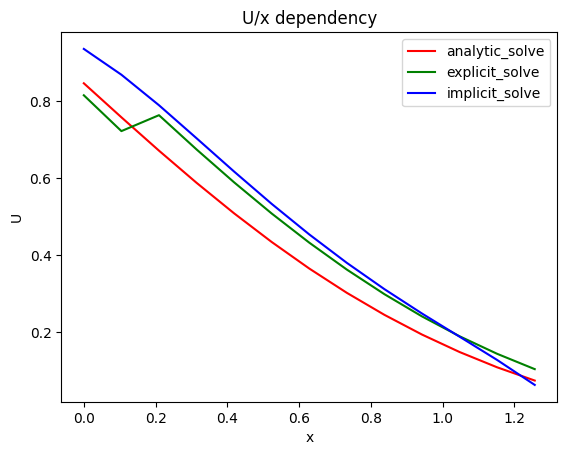

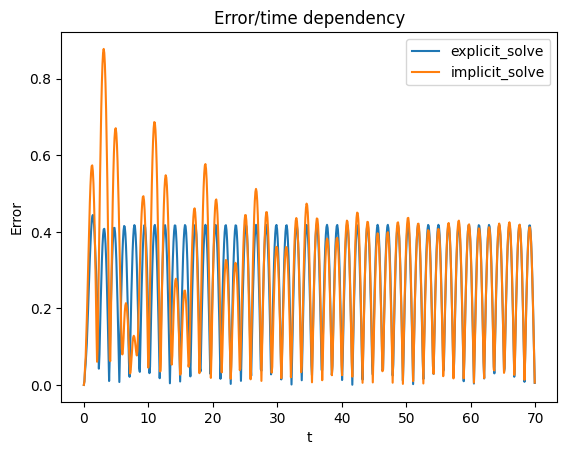

In [121]:
import matplotlib.pyplot as plt

def get_errors(numeric, analytic):
    err = []
    error = [[abs(i - j) for i, j in zip(x, y)] for x, y in zip(numeric, analytic)]
    for i in range(len(error)):
        tmp = 0
        for j in error[i]:
            tmp += j
        err.append(tmp / len(error[i]))
    return err

def draw_plot(answers, N, K, T, time=3):
    fig = plt.figure()
    x = np.arange(0, np.pi / 2, np.pi / 2 / N)
    t = np.arange(0, T, T / K)
    z1 = np.array(answers['analytic_solve'])
    z2 = np.array(answers['explicit_solve'])
    z3 = np.array(answers['implicit_solve'])


    plt.title('U/x dependency')
    plt.plot(x[0:-2], z1[time][0:-2], color='r', label='analytic_solve')
    plt.plot(x[0:-2], z2[time][0:-2], color='g', label='explicit_solve')
    plt.plot(x[0:-2], z3[time][0:-2], color='b', label='implicit_solve')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('x')
    plt.show()


    plt.title('Error/time dependency')
    for method in algorithms:
        plt.plot(t, get_errors(answers[method], answers['analytic_solve']), label=method)
    plt.legend(loc='best')
    plt.ylabel('Error')
    plt.xlabel('t')
    plt.show()

draw_plot(answers, N, K, T)